Time step 0/3600 completed
Time step 100/3600 completed
Time step 200/3600 completed
Time step 300/3600 completed
Time step 400/3600 completed
Time step 500/3600 completed
Time step 600/3600 completed
Time step 700/3600 completed
Time step 800/3600 completed
Time step 900/3600 completed
Time step 1000/3600 completed
Time step 1100/3600 completed
Time step 1200/3600 completed
Time step 1300/3600 completed
Time step 1400/3600 completed
Time step 1500/3600 completed
Time step 1600/3600 completed
Time step 1700/3600 completed
Time step 1800/3600 completed
Time step 1900/3600 completed
Time step 2000/3600 completed
Time step 2100/3600 completed
Time step 2200/3600 completed
Time step 2300/3600 completed
Time step 2400/3600 completed
Time step 2500/3600 completed
Time step 2600/3600 completed
Time step 2700/3600 completed
Time step 2800/3600 completed
Time step 2900/3600 completed
Time step 3000/3600 completed
Time step 3100/3600 completed
Time step 3200/3600 completed
Time step 3300/3600 co

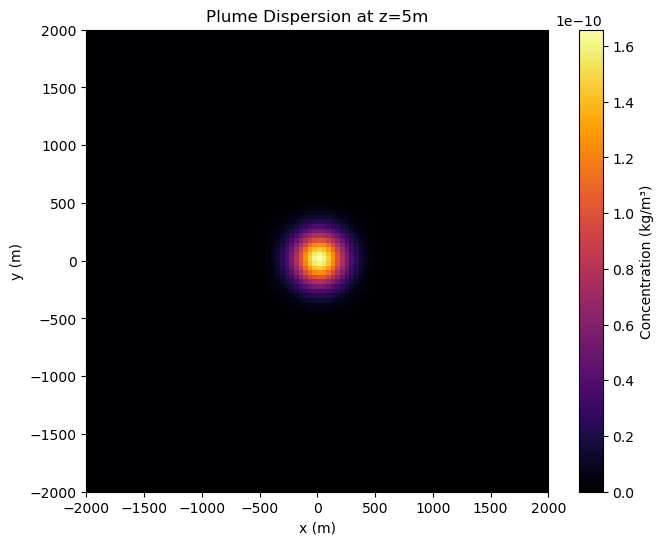

In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

# --- PARAMETERS ---
Nx, Ny, Nz = 100, 100, 50  # Grid points in x, y, z
Lx, Ly, Lz = 2000, 2000, 500  # Domain size (m)
dx, dy, dz = Lx/Nx, Ly/Ny, Lz/Nz  # Grid spacing
dt = 1.0  # Time step (seconds)
T_final = 3600  # Simulation time (seconds)
Nt = int(T_final / dt)  # Number of time steps

# Physical parameters
u_wind = 5.0  # Mean wind speed (m/s)
gamma = 0.3  # Wind power-law exponent
z_ref = 10  # Reference height for wind
s_x, s_y = 1.0, 1.0  # Eddy diffusivities (m^2/s)
s_z = 0.1  # Vertical diffusivity (m^2/s)
u_set = 0.0027  # Settling velocity (m/s)
u_dep = 0.005  # Deposition velocity (m/s)

# --- INITIALIZATION ---
c = np.zeros((Nx, Ny, Nz))  # Concentration field
q = np.zeros((Nx, Ny, Nz))  # Source term

# Source location
source_x, source_y, source_z = Nx//2, Ny//2, Nz//2
q[source_x, source_y, source_z] = 1.0  # Point source

# Wind profile (Power-law)
z_levels = np.linspace(0, Lz, Nz)
u_profile = u_wind * (z_levels / z_ref) ** gamma

# --- FINITE VOLUME DISCRETIZATION ---
def advection_flux(c, u, axis):
    """ Compute upwind advection flux. """
    flux = np.zeros_like(c)
    if axis == 0:  # x-direction
        flux[1:, :, :] = np.maximum(u, 0) * c[:-1, :, :] + np.minimum(u, 0) * c[1:, :, :]
    elif axis == 1:  # y-direction
        flux[:, 1:, :] = np.maximum(u, 0) * c[:, :-1, :] + np.minimum(u, 0) * c[:, 1:, :]
    elif axis == 2:  # z-direction
        flux[:, :, 1:] = np.maximum(u, 0) * c[:, :, :-1] + np.minimum(u, 0) * c[:, :, 1:]
    return flux

def diffusion_term(c, s, dx, axis):
    """ Compute diffusion term using central differencing. """
    diff = np.zeros_like(c)
    if axis == 0:  # x-direction
        diff[1:-1, :, :] = s * (c[:-2, :, :] - 2 * c[1:-1, :, :] + c[2:, :, :]) / dx**2
    elif axis == 1:  # y-direction
        diff[:, 1:-1, :] = s * (c[:, :-2, :] - 2 * c[:, 1:-1, :] + c[:, 2:, :]) / dx**2
    elif axis == 2:  # z-direction
        diff[:, :, 1:-1] = s * (c[:, :, :-2] - 2 * c[:, :, 1:-1] + c[:, :, 2:]) / dz**2
    return diff

# --- TIME INTEGRATION (Godunov Splitting) ---
for n in range(Nt):
    c_new = np.copy(c)

    # Advection in x, y, z directions
    c_new -= dt/dx * (advection_flux(c, u_profile[None, None, :], axis=0) - advection_flux(c, u_profile[None, None, :], axis=0))
    c_new -= dt/dy * (advection_flux(c, u_profile[None, None, :], axis=1) - advection_flux(c, u_profile[None, None, :], axis=1))
    c_new -= dt/dz * (advection_flux(c, u_set, axis=2) - advection_flux(c, u_set, axis=2))

    # Diffusion in x, y, z directions
    c_new += dt * diffusion_term(c, s_x, dx, axis=0)
    c_new += dt * diffusion_term(c, s_y, dy, axis=1)
    c_new += dt * diffusion_term(c, s_z, dz, axis=2)

    # Apply source term
    c_new += dt * q

    # Apply deposition at ground level
    c_new[:, :, 0] -= dt * u_dep * c[:, :, 0]

    # Update solution
    c = np.copy(c_new)

    # Print progress
    if n % 100 == 0:
        print(f"Time step {n}/{Nt} completed")

# --- PLOTTING RESULTS ---
plt.figure(figsize=(8, 6))
plt.imshow(c[:, :, 5].T, origin="lower", cmap="inferno", extent=[-Lx, Lx, -Ly, Ly])
plt.colorbar(label="Concentration (kg/m³)")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Plume Dispersion at z=5m")
plt.show()
